In [19]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _ , filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\fashion-mnist_test.csv
./data\fashion-mnist_train.csv
./data\t10k-images-idx3-ubyte
./data\t10k-labels-idx1-ubyte
./data\train-images-idx3-ubyte
./data\train-labels-idx1-ubyte


In [3]:
data = pd.read_csv('./data/fashion-mnist_test.csv')
data.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0


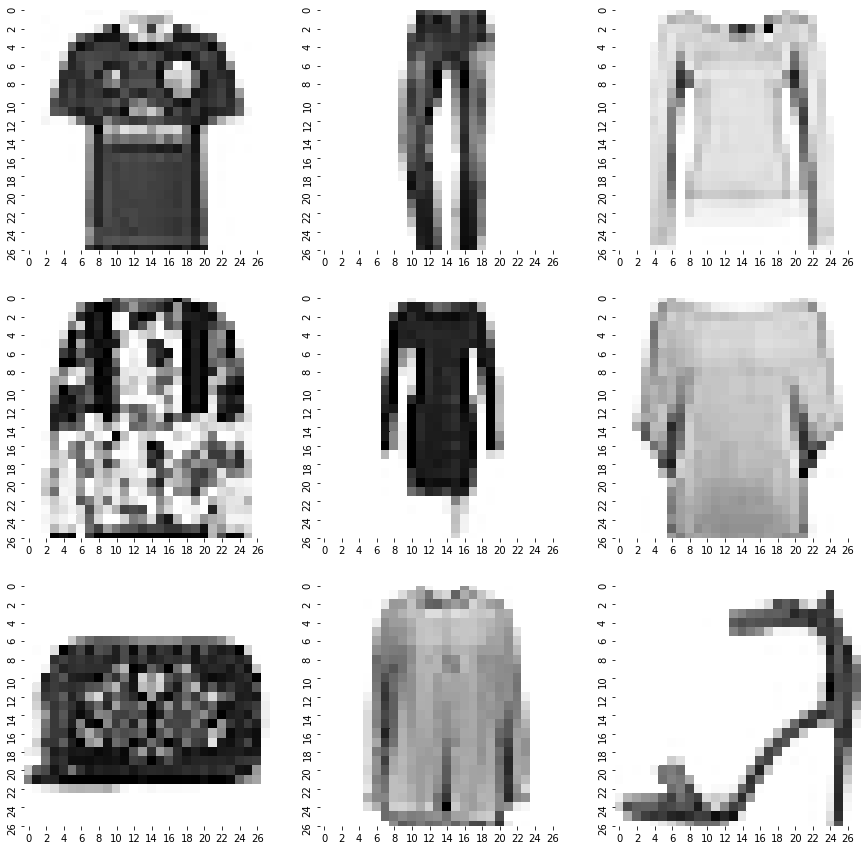

In [18]:
fig = plt.figure(figsize = (15, 15))
for i in range(1, 10):
    fig.add_subplot(3, 3, i)
    sns.heatmap(np.array(data.iloc[i-1, 1:]).reshape(28, 28), cbar = False, cmap = 'Greys');

In [20]:
mean = np.array(data.iloc[:,1:]).flatten().mean()
std = np.array(data.iloc[:,1:]).flatten().std()
print('mean = ', mean)
print('std = ', std)

mean =  73.16080497448979
std =  90.27313431260943


In [24]:
class Fashion(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        dataset = data
        self.labels = dataset.label.values
        self.images = dataset.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [26]:
transf = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize( (mean/225,), (std/225,) )])

data_train = Fashion(pd.read_csv('./data/fashion-mnist_train.csv'),transform=transf)
data_test = Fashion(pd.read_csv('./data/fashion-mnist_test.csv'),transform=transf)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True)

In [27]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        return out

In [28]:
params = []
loss_train = []
loss_test = []

def test(model):
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_id, (image, label) in enumerate(test_loader):
            image = image.view(image.shape[0],-1)
            outputs = model(image)
            
            # add loss to graph
            if (batch_id % 100 == 0) & (batch_id > 0):
                loss = criterion(outputs, label)
                loss_test.append(loss.item())
            predicted = torch.argmax(outputs,dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('Test accuracy: {} %'.format(100 * correct / total))
        
def train():
    model = Net(784, [150,150,150], 10)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, 20):
        for batch_id, (image, label) in enumerate(train_loader):
            image = image.view(image.shape[0],-1)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_id % 1024 == 0:
                print('Loss :{:.4f} Epoch - {}/{} '.format(loss.item(), epoch, 20), end=' ')
                loss_train.append(loss.item())
        test(model)
    for i in model.parameters():
        params.append(i)
    return model

In [29]:
model = train()

Loss :2.3062 Epoch - 1/20  Test accuracy: 83.74 %
Loss :0.5522 Epoch - 2/20  Test accuracy: 85.66 %
Loss :0.4533 Epoch - 3/20  Test accuracy: 86.67 %
Loss :0.3051 Epoch - 4/20  Test accuracy: 86.34 %
Loss :0.3005 Epoch - 5/20  Test accuracy: 87.43 %
Loss :0.2234 Epoch - 6/20  Test accuracy: 87.76 %
Loss :0.2914 Epoch - 7/20  Test accuracy: 88.18 %
Loss :0.1501 Epoch - 8/20  Test accuracy: 87.73 %
Loss :0.2135 Epoch - 9/20  Test accuracy: 88.58 %
Loss :0.3020 Epoch - 10/20  Test accuracy: 88.48 %
Loss :0.3810 Epoch - 11/20  Test accuracy: 88.81 %
Loss :0.2930 Epoch - 12/20  Test accuracy: 88.85 %
Loss :0.3304 Epoch - 13/20  Test accuracy: 88.91 %
Loss :0.2534 Epoch - 14/20  Test accuracy: 89.2 %
Loss :0.1771 Epoch - 15/20  Test accuracy: 89.19 %
Loss :0.1167 Epoch - 16/20  Test accuracy: 88.92 %
Loss :0.1870 Epoch - 17/20  Test accuracy: 89.4 %
Loss :0.2895 Epoch - 18/20  Test accuracy: 88.59 %
Loss :0.1518 Epoch - 19/20  Test accuracy: 88.82 %


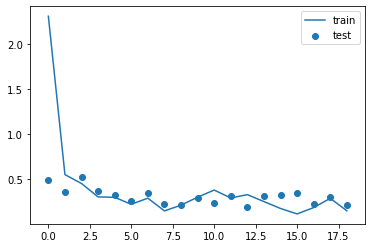

In [30]:
plt.plot(np.arange(19),loss_train, label='train')
plt.scatter(np.arange(19),loss_test, label = 'test')
plt.legend();

Classes - T-shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot


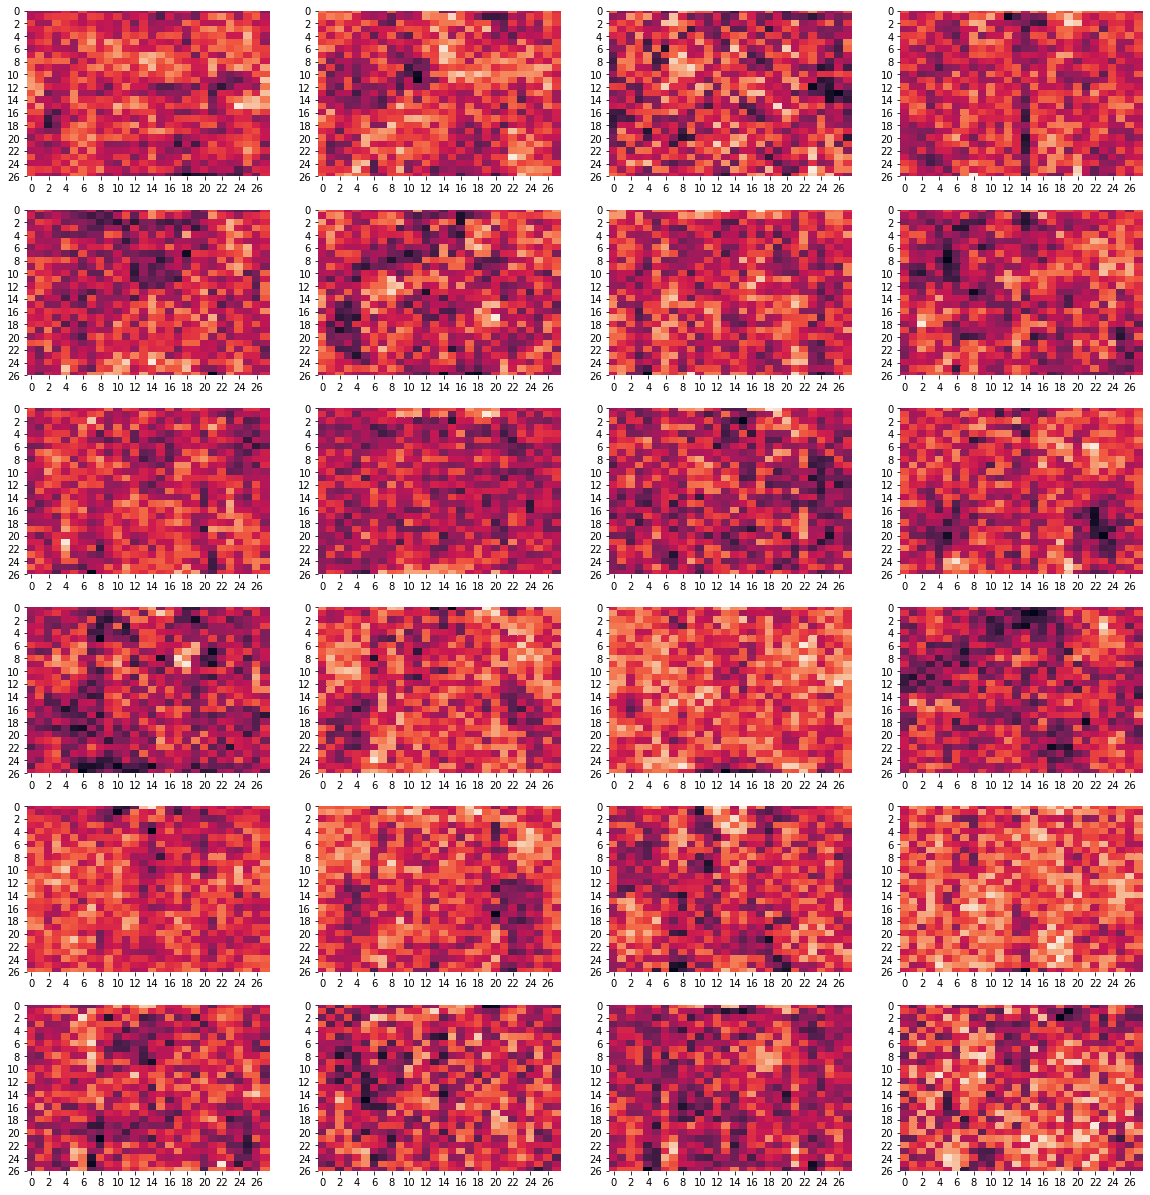

In [31]:
print("Classes - T-shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot")
for i in model.parameters():
        params.append(i)
        
fig = plt.figure(figsize=(20,25))
for i in range(1,25):
    fig.add_subplot(7,4,i)
    sns.heatmap(params[0][i-1,:].reshape(28,28).detach().numpy(), cbar=False);

## NN with one linear layer

In [32]:
class Net(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        return out
params = []
loss_train = []
loss_test = []

def test(model):
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_id, (image, label) in enumerate(test_loader):
            image = image.view(image.shape[0],-1)
            outputs = model(image)
            
            # add loss to graph
            if (batch_id % 100 == 0) & (batch_id > 0):
                loss = criterion(outputs, label)
                loss_test.append(loss.item())
            
            predicted = torch.argmax(outputs,dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('Test accuracy: {} %'.format(100 * correct / total))
        
def train():
    model = Net(784, 10)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, 20):
        for batch_id, (image, label) in enumerate(train_loader):
            image = image.view(image.shape[0],-1)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_id % 1024 == 0:
                print('Loss :{:.4f} Epoch - {}/{}'.format(loss.item(), epoch, 20), end=' ')
                loss_train.append(loss.item())
        test(model)
    for i in model.parameters():
        params.append(i)
    return model
model = train()

Loss :2.3339 Epoch - 1/20 Test accuracy: 79.56 %
Loss :0.7226 Epoch - 2/20 Test accuracy: 81.82 %
Loss :0.5680 Epoch - 3/20 Test accuracy: 83.31 %
Loss :0.5018 Epoch - 4/20 Test accuracy: 83.75 %
Loss :0.4395 Epoch - 5/20 Test accuracy: 84.45 %
Loss :0.3346 Epoch - 6/20 Test accuracy: 84.66 %
Loss :0.4624 Epoch - 7/20 Test accuracy: 84.75 %
Loss :0.4488 Epoch - 8/20 Test accuracy: 84.88 %
Loss :0.5777 Epoch - 9/20 Test accuracy: 85.1 %
Loss :0.4744 Epoch - 10/20 Test accuracy: 85.17 %
Loss :0.4605 Epoch - 11/20 Test accuracy: 85.07 %
Loss :0.6073 Epoch - 12/20 Test accuracy: 85.4 %
Loss :0.2580 Epoch - 13/20 Test accuracy: 85.15 %
Loss :0.5410 Epoch - 14/20 Test accuracy: 85.45 %
Loss :0.5317 Epoch - 15/20 Test accuracy: 85.44 %
Loss :0.4172 Epoch - 16/20 Test accuracy: 85.44 %
Loss :0.4421 Epoch - 17/20 Test accuracy: 85.55 %
Loss :0.3389 Epoch - 18/20 Test accuracy: 85.63 %
Loss :0.3265 Epoch - 19/20 Test accuracy: 85.51 %


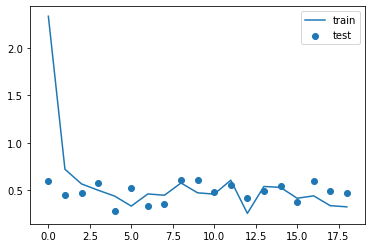

In [33]:
plt.plot(np.arange(19),loss_train, label='train')
plt.scatter(np.arange(19),loss_test, label = 'test')
plt.legend();

Classes - T-shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot


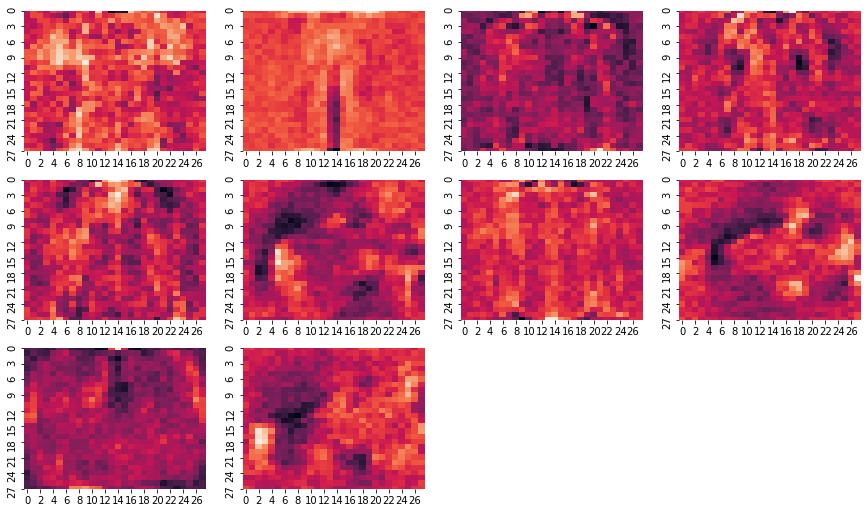

In [34]:
print("Classes - T-shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot")
for i in model.parameters():
        params.append(i) 
fig = plt.figure(figsize=(15,15))
for i in range(1,11):
    fig.add_subplot(5,4,i)
    sns.heatmap(params[0][i-1,:].reshape(28,28).detach().numpy(), cbar=False);

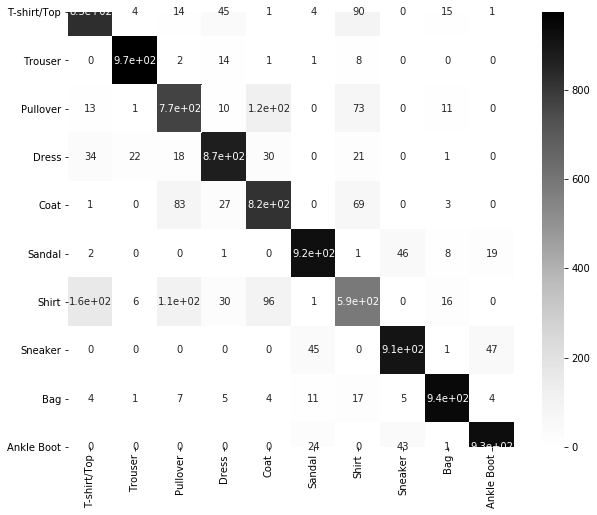

In [35]:
nb_classes = 10
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i,  (image, classes) in enumerate(test_loader):
        image = image.view(image.shape[0],-1)
        outputs = model(image)
        _, preds = torch.max(outputs, dim=1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
cols = ["T-shirt/Top", "Trouser", "Pullover","Dress","Coat", "Sandal", "Shirt","Sneaker","Bag","Ankle Boot"]
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(np.array(confusion_matrix), columns=cols, index=cols), cmap='Greys', annot=True);

# Reference
- https://www.kaggle.com/nikitagrec/explore-nn-with-pytorch